In [7]:
# import utils
import numpy as np
import pandas as pd
from scipy.stats import norm
from skbio.stats.composition import closure
from numpy.random import poisson, lognormal, normal
from numpy.linalg import eig
from scipy.stats import bernoulli

# import DEICODE
import qiime2 as q2
from biom import Table
from qiime2.plugins.deicode.actions import rpca
from skbio import OrdinationResults
from deicode.preprocessing import rclr

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline


In [3]:

def chain_interactions(gradient, mu, sigma):
    xs = [norm.pdf(gradient, loc=mu[i], scale=sigma[i])
          for i in range(len(mu))]
    return np.vstack(xs) 

def model_data(n_features = 5000, n_samples = 100,
               pi1 = 0.3, pi2 = 0.3, mu_neg = 1,
               mu_null = 5, mu_pos = 7,
               sigma = 0.1, depth = 50000,
               disp = .40, kappa = .01):
    
    g = np.linspace(2, 8, n_samples)
    mu_pos_hat = normal(mu_pos, sigma,
                        size=int(round(pi1 * n_features)))
    mu_neg_hat = normal(mu_neg, sigma,
                        size=int(round(pi2 * n_features)))
    mu_null_hat = normal(mu_null, sigma,
                         size=int(round((1-pi1-pi2) * n_features)))
    mu = np.hstack((mu_pos_hat, mu_null_hat, mu_neg_hat))

    sigma = [disp] * n_features
    x = chain_interactions(g, mu=mu, sigma=sigma)
    mu = depth * closure(x.T).T
    y = np.vstack([poisson(lognormal(np.log(mu[:, i]), kappa))
                   for i in range(n_samples)]).T
    y += np.random.randint(0, 600, (n_features, n_samples))
    sample_id = ['sample%i'%i for i in range(n_samples)]
    feature_id = ['otu%i'%i for i in range(n_features)]
    
    return pd.DataFrame(y, feature_id, sample_id)


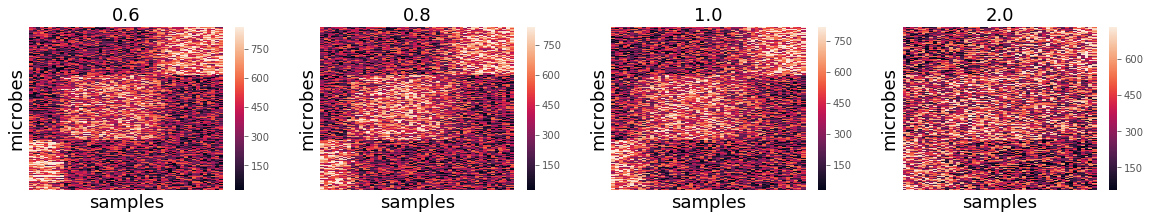

In [69]:
# requested perams
m , n = (500, 50)
disps_ = [0.6, 0.8, 1.0, 2.0]

# generate models
models = {disp_: model_data(n_features = m,
                        n_samples = n,
                        disp = disp_)
          for i, disp_ in  enumerate(disps_)}

# inspect each model 
fig, axns = plt.subplots(1, len(disps_),
                         figsize=(5*len(disps_), 3))

for i, ax in enumerate(axns):
    
    sns.heatmap(models[disps_[i]], ax=ax,
                robust=True,
                xticklabels=False,
                yticklabels=False)
    ax.tick_params(axis='both',
               which='both',
               length=0)

    title_ = str(disps_[i])
    ax.set_title(title_,
                 fontsize=18)
    ax.set_ylabel('microbes',
                  fontsize=18,
                  color='black')
    ax.set_xlabel('samples',
                  fontsize=18,
                  color='black')

plt.show()

In [74]:
# inc. for plots
incriment = 12
ords = {}
prop = {}
# repeat for each table
for disp_, table_df in models.items():

    # make metadata
    labels_ = table_df.columns
    labels_ = {y:['group %i' % (i+1)] for i in range(3)
               for y in list(labels_[(len(table_df.columns)//3 * i): \
                                     (len(table_df.columns)//3 * (i + 1))])}
    labels_ = pd.DataFrame(labels_, ['grouping']).T

    # import table
    table_ = Table(table_df.values,
                   table_df.index,
                   table_df.columns)
    table_ = q2.Artifact.import_data('FeatureTable[Frequency]',
                                     table_)

    # get steps
    steps = np.arange(2, table_df.shape[1] + incriment, incriment)
    steps[-1] =  table_df.shape[1] - 4

    # increae rank used
    ords_ = {}
    prop_ = {}
    for rank_ in steps:

        # do dimentionality reductions
        rpca_res = rpca(table_, n_components = rank_)
        rpca_ord = rpca_res.biplot.view(OrdinationResults)
        # save ordination
        ords_[rank_] =  pd.concat([rpca_ord.samples,labels_],
                                  axis=1, sort=False)
        # previous
        prev_frac = rpca_ord.eigvals.values**2 / np.sum(rpca_ord.eigvals.values**2)
        # new prop.
        X_proj = rpca_ord.samples.values * rpca_ord.eigvals.values
        tot_var =  np.nansum(np.nanvar(rclr(table_df.values), axis=1))
        new_frac = np.var(X_proj, axis=0) / tot_var
        # save frac explained
        prop_[rank_] = [prev_frac, new_frac]

    # save for model
    ords[disp_] = ords_
    prop[disp_] = prop_


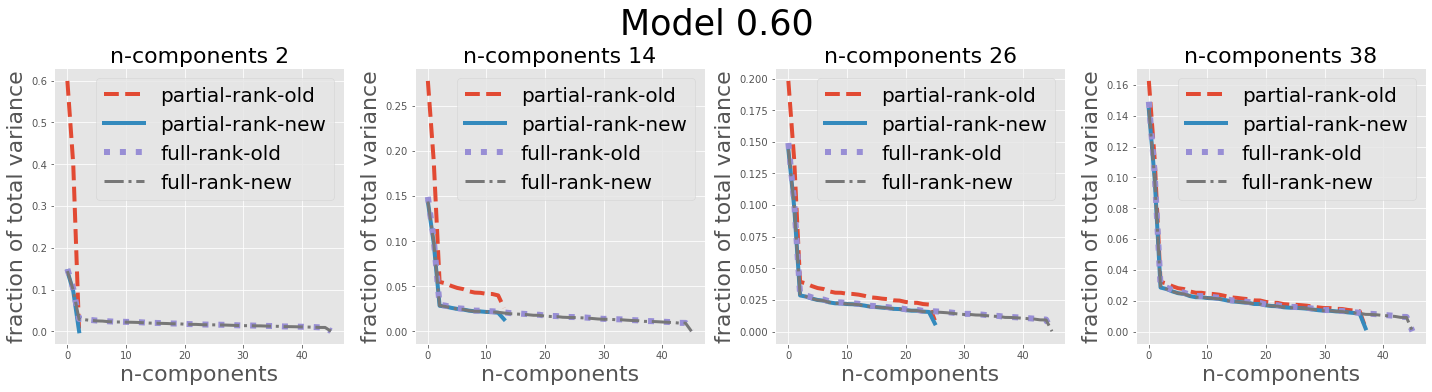

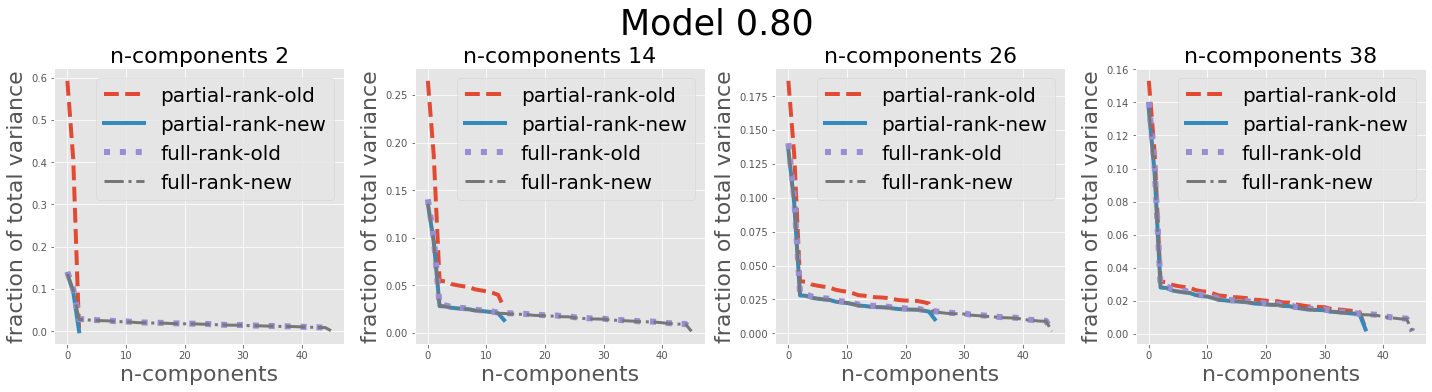

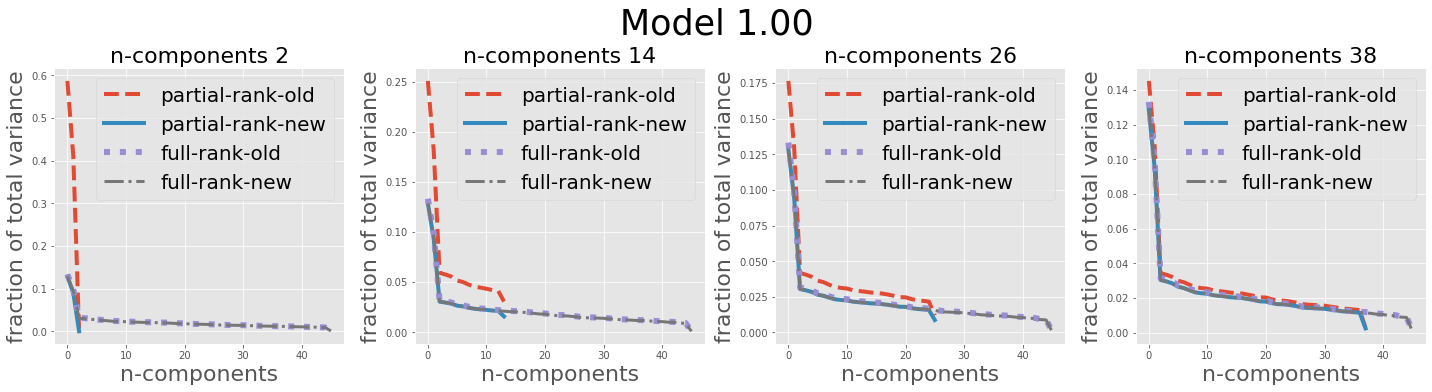

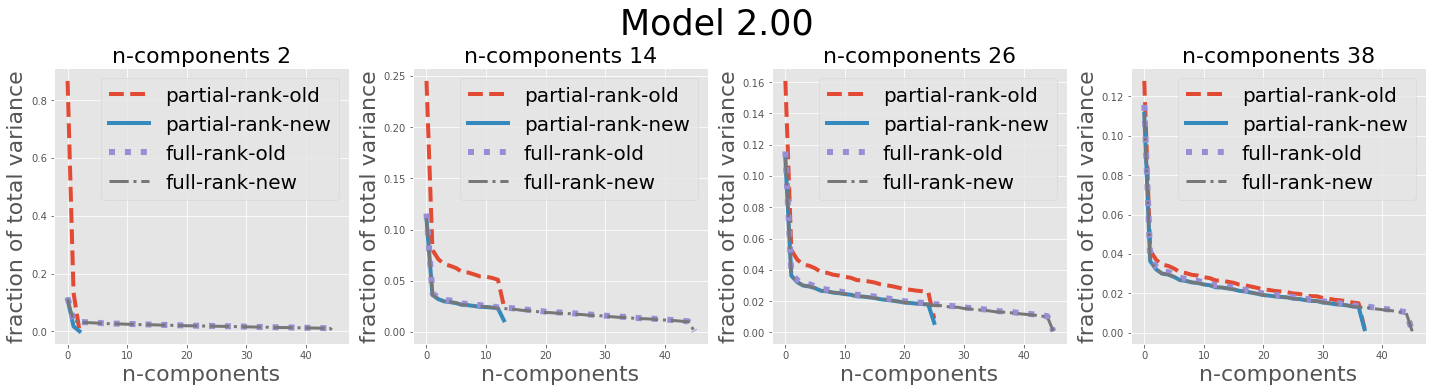

In [75]:
# inspect each model's frac. exp.
n_show = list(range(len(steps[:-1])))

# for each model
for disp_, prop_ in prop.items():

    fig, axns = plt.subplots(1, len(n_show),
                             figsize=(5*len(n_show),
                                      5))

    for ax, rank_ in zip(axns.flatten(),
                         [steps[i] for i in n_show]):

        ax.plot(prop_[rank_][0], label='partial-rank-old',ls='--', lw=4)
        ax.plot(prop_[rank_][1], label='partial-rank-new',ls='-', lw=4)
        ax.plot(prop_[steps[-1]][0], label='full-rank-old',ls=':', lw=6)
        ax.plot(prop_[steps[-1]][1], label='full-rank-new',ls='-.', lw=3)


        ax.legend(loc='best', prop={'size':20})
        ax.set_xlabel('n-components',
                      fontsize=22)
        ax.set_ylabel('fraction of total variance',
                      fontsize=22)
        title_ = str('n-components %i' % rank_)
        ax.set_title(title_,
                     fontsize=22)

    plt.suptitle('Model %.2f' % disp_, fontsize=35,
                 y=1.08, color='black')
    plt.tight_layout()
    plt.show()


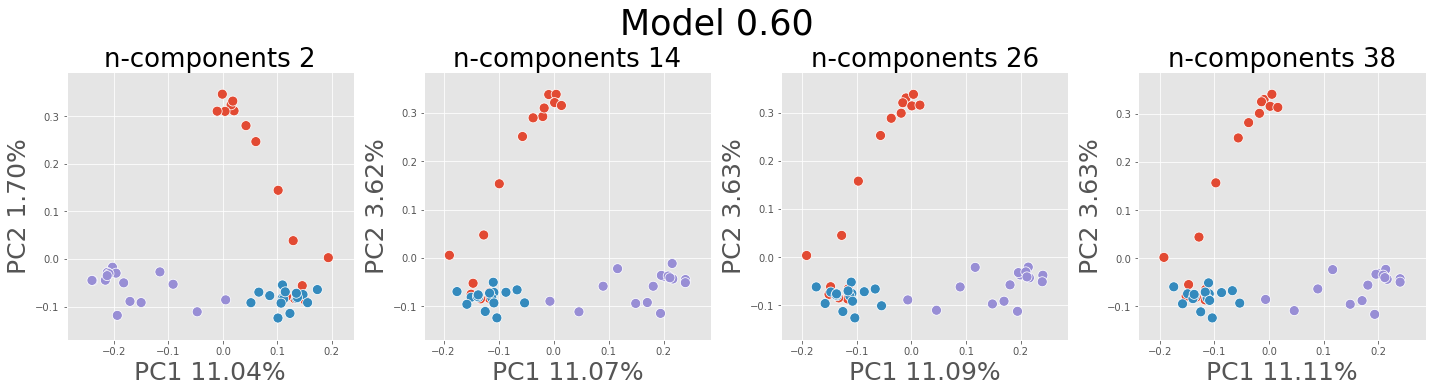

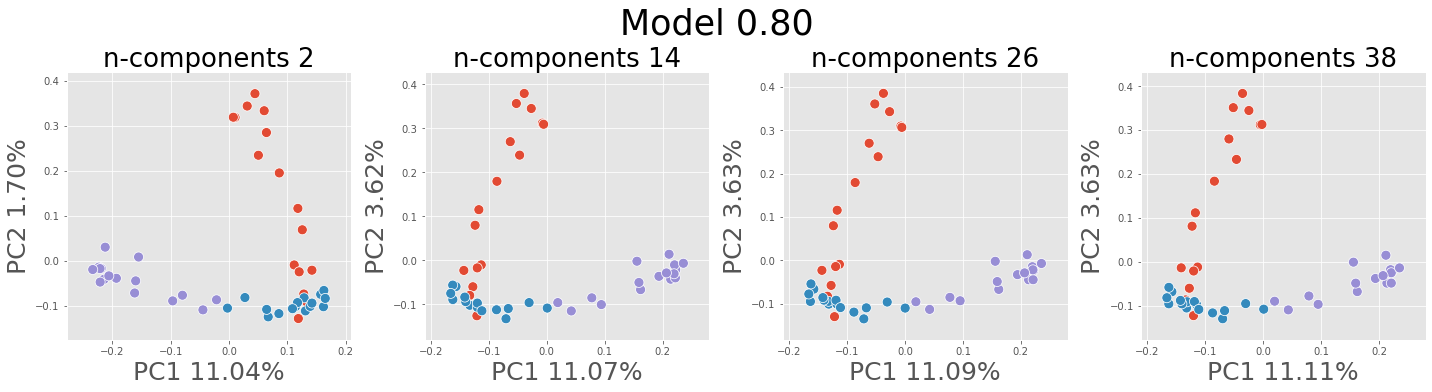

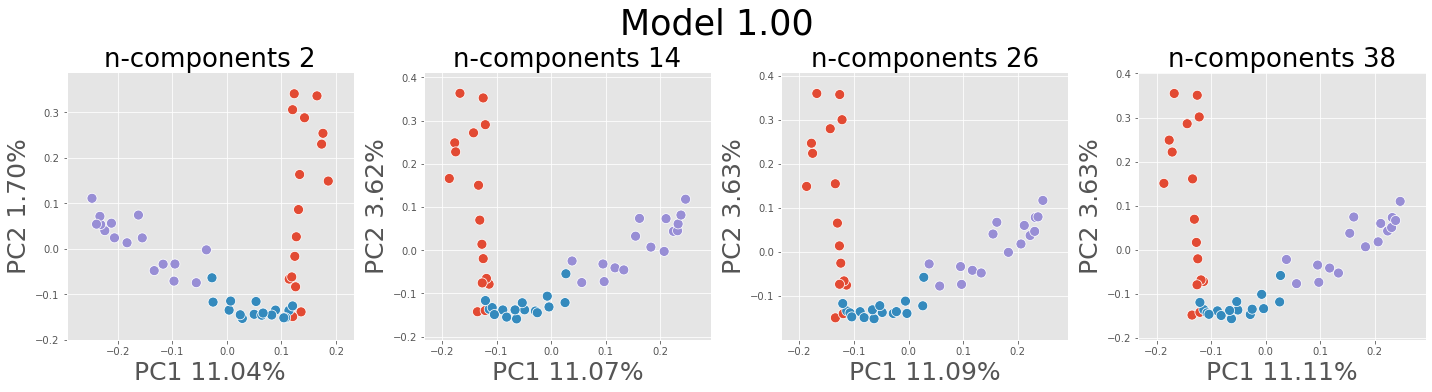

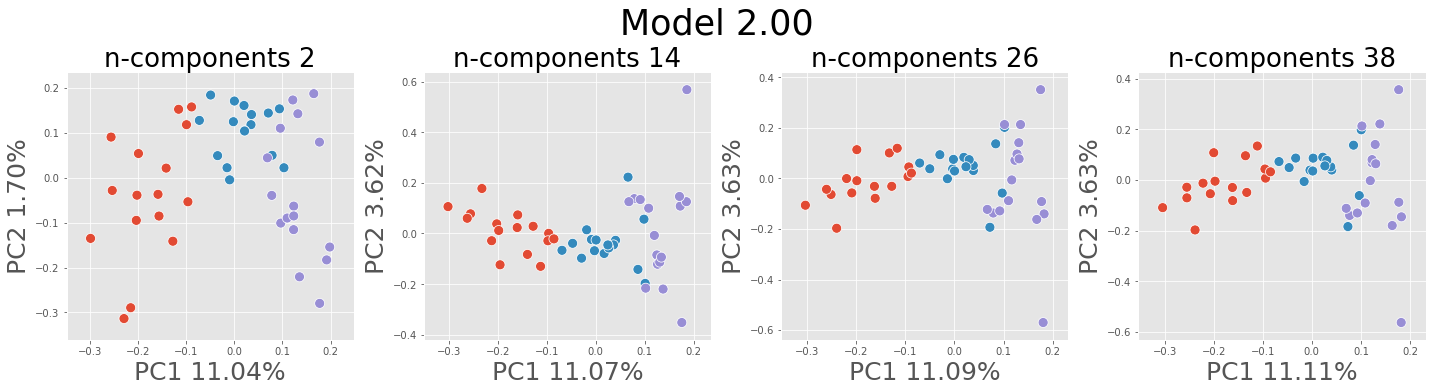

In [76]:
# for each model
for disp_, ords_ in ords.items():

    fig, axns = plt.subplots(1, len(n_show),
                             figsize=(5*len(n_show),
                                      5))

    for ax, rank_ in zip(axns.flatten(),
                         [steps[i] for i in n_show]):

        sns.scatterplot(x=0, y=1,
                        hue='grouping',
                        data=ords_[rank_],
                        ax=ax, s=100)
        ax.legend_.remove()

        pc1_label = 'PC1 %.2f%%' % (prop_[rank_][1][0] * 100)
        pc2_label = 'PC2 %.2f%%' % (prop_[rank_][1][1] * 100)
        ax.set_xlabel(pc1_label,
                      fontsize=25)
        ax.set_ylabel(pc2_label,
                      fontsize=25)
        title_ = str('n-components %i' % rank_)
        ax.set_title(title_,
                     fontsize=26)
    plt.suptitle('Model %.2f' % disp_, fontsize=35,
                 y=1.08, color='black')
    plt.tight_layout()
    plt.show()